In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

import matplotlib.cm as cm
from scipy import optimize
from mpl_toolkits.mplot3d import Axes3D

In [121]:
def affine_line(s, theta, phi, x0, y0, z0):
    a = np.sin(theta) * np.cos(phi)
    b = np.sin(theta) * np.sin(phi)
    c = np.cos(theta)
    return np.array([s*a + x0, s*b+y0, s*c+z0])


def point_to_line_distance(x,y,z,theta,phi,x0,y0,z0):
    xx = x - x0
    yy = y - y0
    zz = z - z0
    
    a = np.sin(theta) * np.cos(phi)
    b = np.sin(theta) * np.sin(phi)
    c = np.cos(theta)
    
    r = np.array([xx, yy, zz])
    t = np.array([a,b,c])
    
    return np.linalg.norm(r - np.dot(r,t)*t)


def residuals(parameters, fixpoint, data, weights=None):
    theta, phi = parameters
    x0, y0, z0 = fixpoint
    if weights is None:
        w = np.ones(len(data))
    else:
        w = np.array(weights)
        
    diff = np.array([ point_to_line_distance(x,y,z,theta,phi,*fixpoint) for x,y,z in data])
    diff = diff*w
    return diff


def point_to_point_distance(p,q):
    squared_dist = np.sum((p-q)**2, axis=0)
    dist = np.sqrt(squared_dist)
    return dist

In [24]:

neuron = "swcs_ivscc/test.swc"

df = pd.read_csv(neuron, delimiter=' ')


In [25]:
swc = df.values

In [26]:
print(swc.shape)

(2171, 7)


In [27]:
# 0    1   2  3  4  5   6
# id type  x  y  z  r  pid

swc

array([[ 1.000000e+00,  1.000000e+00,  2.725008e+02, ...,  3.304000e+01,
         6.239900e+00, -1.000000e+00],
       [ 2.000000e+00,  4.000000e+00,  2.752350e+02, ...,  3.402170e+01,
         2.020000e-01,  1.000000e+00],
       [ 3.000000e+00,  4.000000e+00,  2.758676e+02, ...,  3.436240e+01,
         2.620000e-01,  2.000000e+00],
       ...,
       [ 2.169000e+03,  3.000000e+00,  2.809664e+02, ...,  3.844620e+01,
         1.271000e-01,  2.168000e+03],
       [ 2.170000e+03,  3.000000e+00,  2.813016e+02, ...,  3.835440e+01,
         1.144000e-01,  2.169000e+03],
       [ 2.171000e+03,  3.000000e+00,  2.811952e+02, ...,  3.892000e+01,
         1.144000e-01,  2.170000e+03]])

In [30]:
print(swc[0,0], swc[0,6])

1.0 -1.0


In [31]:
n, m = swc.shape

In [32]:
print(n)

2171


In [33]:
branch = np.zeros(n)

In [35]:
print(branch, branch.shape)

[0. 0. 0. ... 0. 0. 0.] (2171,)


In [37]:
for i in range(1, n-1):
    branch[ int(swc[i,6])-1 ] = branch[ int(swc[i,6])-1 ] + 1

In [44]:
print(len(list(x for x in branch if x==2)))

19


In [53]:
print(np.where(branch>=2))

(array([   0,    4,   10,   21,   46,   57,   82,  567,  741,  956, 1105,
       1208, 1319, 1527, 1589, 1592, 1608, 1630, 1908, 2032]),)


In [50]:
print(swc[4,0], np.where(swc[:,6]==swc[4,0]))

5.0 (array([   5, 1178]),)


In [51]:
print(swc[1178,6])

5.0


In [52]:
print(np.where(swc[:,6]==1))

(array([   1, 1501, 1582, 1841, 1863, 2015]),)


In [153]:
# split swc into fragments

n, m = swc.shape
branches = np.zeros(n)

for i in range(1, n-1):
    branches[ int(swc[i,6])-1 ] = branches[ int(swc[i,6])-1 ] + 1
    
idxBranchNodes = np.where(branches >= 2)

idxNodes = idxBranchNodes[0]

print(idxNodes)

nBranches = idxNodes.size

print(nBranches)

length = np.zeros(1)
linelike = np.zeros(1) # average distance of points to line

for i in range(0, nBranches-1):
    
    print("explort branch", i)
    index = idxNodes[i]
    
    val = swc[index,0]
    
    nextNodes = np.where(swc[:,6] == val)
    
    fragments = nextNodes[0]
    
    nFrags = fragments.size
    
    print(nFrags)
    
    x = np.array([ swc[index,2] ])
    y = np.array([ swc[index,3] ])
    z = np.array([ swc[index,4] ])

    #data[:,0] = np.array( [ swc[index,2], swc[index,3], swc[index,4] ])
    
    for j in range(0, nFrags):
        node = fragments[j]
        
        result = np.where(swc[:,6]==swc[node,0])
        
        x = np.insert(x, x.size, swc[node,2])
        y = np.insert(y, y.size, swc[node,3])
        z = np.insert(z, z.size, swc[node,4])
        
        while result[0].size > 0:
            node = result[0][0]
            
            x = np.insert(x, x.size, swc[node,2])
            y = np.insert(y, y.size, swc[node,3])
            z = np.insert(z, z.size, swc[node,4])
            
            result = np.where(swc[:,6]==swc[node,0])
            
        data = np.transpose(np.array([x,y,z]))
        nData,mData = data.shape
        print("frag",j,data.shape)
        
        fixpoint = np.array([ np.mean(data[:,0]), np.mean(data[:,1]), np.mean(data[:,2]) ] )
        bestfitW, success = optimize.leastsq(residuals, [0,0], args=(fixpoint, data) )
                                             
        diff = residuals(bestfitW, fixpoint, data)
        linelike = np.insert(linelike, linelike.size, np.mean(diff))

        lengthFrag = 0
        for i in range(1,nData):
            p = data[i-1]
            q = data[i]
            lengthFrag = lengthFrag + point_to_point_distance(p,q)

        length = np.insert(length, length.size, lengthFrag)

# remove the first element init by 0
length = np.delete(length, 0,0)
linelike = np.delete(linelike, 0,0)

print(length.shape, linelike.shape)

totallength = np.sum(length)

print(totallength)
print(linelike)









[   0    4   10   21   46   57   82  567  741  956 1105 1208 1319 1527
 1589 1592 1608 1630 1908 2032]
20
explort branch 0
6
frag 0 (467, 3)
frag 1 (533, 3)
frag 2 (631, 3)
frag 3 (653, 3)
frag 4 (750, 3)
frag 5 (862, 3)
explort branch 1
2
frag 0 (463, 3)
frag 1 (604, 3)
explort branch 2
2
frag 0 (457, 3)
frag 1 (592, 3)
explort branch 3
2
frag 0 (446, 3)
frag 1 (569, 3)
explort branch 4
2
frag 0 (421, 3)
frag 1 (518, 3)
explort branch 5
2
frag 0 (410, 3)
frag 1 (439, 3)
explort branch 6
2
frag 0 (385, 3)
frag 1 (443, 3)
explort branch 7
2
frag 0 (84, 3)
frag 1 (144, 3)
explort branch 8
2
frag 0 (93, 3)
frag 1 (199, 3)
explort branch 9
2
frag 0 (119, 3)
frag 1 (206, 3)
explort branch 10
2
frag 0 (57, 3)
frag 1 (73, 3)
explort branch 11
2
frag 0 (111, 3)
frag 1 (218, 3)
explort branch 12
2
frag 0 (107, 3)
frag 1 (182, 3)
explort branch 13
2
frag 0 (40, 3)
frag 1 (55, 3)
explort branch 14
2
frag 0 (91, 3)
frag 1 (133, 3)
explort branch 15
2
frag 0 (88, 3)
frag 1 (126, 3)
explort branch 1

In [92]:



result = np.where(swc[:,6]==3000)

#print(dir(result), result[0].size)


branchnode = swc[4,0]

nextnodes = np.where(swc[:,6]==branchnode)

nodes = nextnodes[0]

x = np.array([ swc[4,2] ])
y = np.array([ swc[4,3] ])
z = np.array([ swc[4,4] ])

print(x, y, z)


print(nodes)



x = np.insert(x, x.size, swc[5,2])
y = np.insert(y, y.size, swc[5,3])
z = np.insert(z, z.size, swc[5,4])



result = np.where(swc[:,6]==swc[5,0])

print(result)

while result[0].size > 0:
    index = result[0][0]
    print(index)
    
    x = np.insert(x, x.size, swc[index,2])
    y = np.insert(y, y.size, swc[index,3])
    z = np.insert(z, z.size, swc[index,4])
    
    result = np.where(swc[:,6]==swc[index,0])






[277.0871] [513.7407] [35.4936]
[   5 1178]
(array([6]),)
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265


In [112]:
print(np.max(x), np.min(x), np.max(y), np.min(y), np.max(z), np.min(z))

461.60400000000004 277.0871 513.7407 132.7246 79.24 35.4936


In [113]:

# 3d line fit

data = np.transpose(np.array([x,y,z]))

fixpoint = np.array([ np.mean(data[:,0]), np.mean(data[:,1]), np.mean(data[:,2]) ] )

bestfitW, success = optimize.leastsq(residuals, [0,0], args=(fixpoint, data) )

uwline = np.array([ affine_line(s, bestfitW[0], bestfitW[1], *fixpoint) for s in np.linspace(0, 600, 600) ])

print(bestfitW)

[ 1.47220332 -1.11500084]


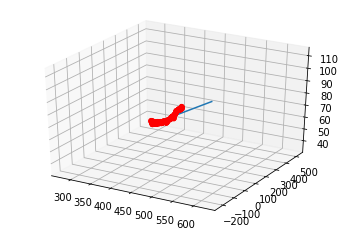

In [116]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x,y,z, c='r')
ax.plot(*np.transpose(uwline))

plt.show()

In [119]:
diff = residuals(bestfitW, fixpoint, data)

print(diff.shape, data.shape)

(463,) (463, 3)


In [120]:
print(np.mean(diff))

4.754535571368078


In [124]:
n,m = data.shape

length = 0
for i in range(1,n):
    p = data[i-1]
    q = data[i]
    length = length + point_to_point_distance(p,q)
    
print(length)

446.79241641672604


In [149]:
print(length, linelike)

[ 455.25401087  950.0572011  1121.84858854 1232.71668116 1361.70348624
  446.79241642  440.51041619  429.28042829  404.95107656  394.49784652
  371.25137134   75.7973557    88.95085067  119.33903252   54.6426128
  102.44238057  108.2400188    37.77840588   97.93916134   94.51650859
   77.01112712   52.19835277   51.21078899] [ 4.82297726  7.66666388 13.01207172 13.11647779 17.67871958  4.75453557
  4.62927949  4.37517012  3.52738463  3.17140282  2.72010378  1.18408352
  1.67427427  3.72779355  1.1773547   1.83174784  3.0034355   1.02730801
  3.67945627  3.44477231  2.92548818  2.53568177  1.28173588]


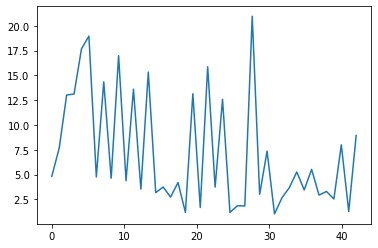

In [154]:
n = linelike.size

x = np.linspace(0,n,n)

plt.plot(x, linelike)

plt.show()

In [156]:
sum = 0
for i in range(0, n):
    if linelike[i]<8:
        sum = sum + length[i]
        
print(sum/totallength)

0.42526977682735284


In [157]:
print(linelike.dtype)

float64
